# Maching Learning - Neural Networks

CS 640
<br>      This code is about how to implement Neural Networks

In [1]:
# Import Python libraries
import numpy as np
import matplotlib.pyplot as plt
import copy

## Neural network class to create the models

In [2]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initializes the parameters of the Neural Network to random values.
        
        args:
            input_dim: Number of dimensions of the input data
            hidden_dim: Number of nodes in the hidden layer
            output_dim: Number of classes
        """
        # Weight vector between input layer and hidden layer
        self.theta1 = np.random.randn(input_dim, hidden_dim) /np.sqrt(input_dim)
        
        # Bias for hidden layer 
        self.bias1 = np.zeros((1, hidden_dim))
        
        # Weight vector between hidden layer and output layer   
        self.theta2 = 2 * np.random.randn(hidden_dim, output_dim) /np.sqrt(hidden_dim)
        
        # Bias for output layer
        self.bias2 = np.zeros((1, output_dim))
        
        # These set of variables perform the same function as above but are used for regularization
        self.tempt1 = copy.deepcopy(self.theta1)                        
        self.tempb1 = copy.deepcopy(self.bias1)
        self.tempt2 = copy.deepcopy(self.theta2)
        self.tempb2 = copy.deepcopy(self.bias2)

        
    def compute_cost(self, X, y):
        '''
        Computes cost of regularization without L2
        '''
        m = X.shape[0]                                                  # number of samples
        z2 = np.dot(X,self.theta1) + self.bias1                         # net input to hidden layer
        a2 = np.tanh(z2)                                                # output from hidden layer
        z3 = np.dot(a2, self.theta2) + self.bias2                       # net input to output layer
        a3 = np.exp(z3) / np.sum(np.exp(z3), axis=1, keepdims=True)     # output from output layer (final output)
        one_hot_y = np.zeros((m,np.max(y)+1))
        for i in range(np.shape(X)[0]):
            one_hot_y[i,y[i]] = 1                                       # expected output
        
        # calculates loss in a single iteration (function used is "cross-entropy loss")
        logprobs = np.multiply(one_hot_y, np.log(a3)) + np.multiply((1-one_hot_y), np.log(1-a3))
        
        # total cost of entire training set
        cross_entropy_cost = (-1.0/m) * np.sum(logprobs)
        return cross_entropy_cost
    
    def fit(self, X, y, num_epochs, alpha=0.01, print_cost=False):
        '''
        Trains the neural network (without L2 regularization)
        '''
        # Model will train itself over the number of epochs specified
        for epoch in range(0, num_epochs):
            
            # Get number of samples
            m = X.shape[0]
            
            # Forward propagation
            z2 = np.dot(X,self.theta1) + self.bias1
            a2 = np.tanh(z2)
            z3 = np.dot(a2, self.theta2) + self.bias2
            a3 = np.exp(z3) / np.sum(np.exp(z3), axis=1, keepdims=True)
            
            # Backpropagation
            beta3 = np.zeros_like(a3)
            beta2 = np.zeros_like(a2)
            one_hot_y = np.zeros_like(a3)
            for i in range(X.shape[0]):
                one_hot_y[i,y[i]] = 1                                        # Expected output
            
            beta3 = a3 - one_hot_y                                           # Error at output layer
            
            # Compute gradients of model parameters
            dtheta2 = 1/m*(a2.T).dot(beta3)                                  # Change in theta2
            dbias2 = 1/m*np.sum(beta3, axis=0)                               # Change in bias2
            
            beta2 = np.multiply(beta3.dot(self.theta2.T),(1-np.power(a2,2))) # Error at hidden layer
            
            dtheta1 = 1/m*np.dot(X.T,beta2)                                  # Change in theta1
            dbias1 = 1/m*np.sum(beta2, axis=0)                               # Change in bias1

            # Reflecting the changes in weights and biases
            self.theta1 -= alpha * dtheta1
            self.bias1 -= alpha * dbias1
            self.theta2 -= alpha * dtheta2
            self.bias2 -= alpha * dbias2
            
            #Prints the cost of the iteration for every 100th epoch (Printing every epoch will create a huge output stream)
            if epoch%100 == 0 and print_cost:
                print("Cost", epoch/100, ":", self.compute_cost(X,y))
        return 0

    def predict(self, X):
        """
        Makes a prediction based on current model parameters.
        
        args:
            X: Data array
            
        returns:
            predictions: array of predicted labels
        """
        z2 = np.dot(X,self.theta1) + self.bias1
        a2 = np.tanh(z2)
        z3 = np.dot(a2, self.theta2) + self.bias2
        a3 = np.exp(z3) / np.sum(np.exp(z3), axis=1, keepdims=True)
        predictions = np.argmax(a3, axis = 1)
        return predictions
        
    def compute_cost_with_regularization(self, X, y, lambd=0.7):
        '''
        Computes cost of regularization with L2
        '''
        m = X.shape[0]                                              
        z2 = np.dot(X,self.tempt1) + self.tempb1
        a2 = np.tanh(z2)
        z3 = np.dot(a2, self.tempt2) + self.tempb2
        a3 = np.exp(z3) / np.sum(np.exp(z3), axis=1, keepdims=True)
        one_hot_y = np.zeros((m,np.max(y)+1))
        for i in range(np.shape(X)[0]):
            one_hot_y[i,y[i]] = 1
        
        logprobs = np.multiply(one_hot_y, np.log(a3)) + np.multiply((1-one_hot_y), np.log(1-a3))
        cross_entropy_cost = (-1.0/m) * np.sum(logprobs)
        
        # The term below is the added cost after adding L2 regularization
        L2_regularization_cost = (np.sum(np.square(self.tempt1)) + np.sum(np.square(self.tempt2)))*(lambd/(2*m))
        
        # The final cost is the sum of cross entropy cost and L2 cost
        cost = cross_entropy_cost + L2_regularization_cost
        cost = np.squeeze(cost)
        return cost
        
    def fit_with_regularization(self, X, y, num_epochs, alpha=0.01, lambd=0.7, print_cost=False):
        '''
        Trains the neural network (with L2 regularization)
        '''
        for epoch in range(0, num_epochs):

            # Get number of samples
            m = X.shape[0]
            
            # Forward propagation
            z2 = np.dot(X,self.tempt1) + self.tempb1
            a2 = np.tanh(z2)
            z3 = np.dot(a2, self.tempt2) + self.tempb2
            a3 = np.exp(z3) / np.sum(np.exp(z3), axis=1, keepdims=True)
            
            # Backpropagation
            beta3 = np.zeros_like(a3)
            beta2 = np.zeros_like(a2)
            one_hot_y = np.zeros_like(a3)
            for i in range(X.shape[0]):
                one_hot_y[i,y[i]] = 1
            beta3 = a3 - one_hot_y
            
            # Compute gradients of model parameters by adding L2 regularization parameter
            dtheta2 = 1/m*(a2.T).dot(beta3) + (lambd/m)*self.tempt2
            dbias2 = 1/m*np.sum(beta3, axis=0)
            
            beta2 = np.multiply(beta3.dot(self.tempt2.T),(1-np.power(a2,2)))
            
            dtheta1 = 1/m*np.dot(X.T,beta2) + (lambd/m)*self.tempt1
            dbias1 = 1/m*np.sum(beta2, axis=0)            

            # Gradient descent parameter update
            self.tempt1 -= alpha * dtheta1
            self.tempb1 -= alpha * dbias1
            
            self.tempt2 -= alpha * dtheta2
            self.tempb2 -= alpha * dbias2
            
            if epoch%100 == 0 and print_cost:
                print("Cost", epoch/100, ":", self.compute_cost_with_regularization(X,y,lambd))
        return 0

    def predict_with_regularization(self, X):
        """
        Makes a prediction based on model with regularized weights
        """
        z2 = np.dot(X,self.tempt1) + self.tempb1
        a2 = np.tanh(z2)
        z3 = np.dot(a2, self.tempt2) + self.tempb2
        a3 = np.exp(z3) / np.sum(np.exp(z3), axis=1, keepdims=True)
        predictions = np.argmax(a3, axis = 1)
        return predictions

### Plot boundary functions

In [3]:
def plot_decision_boundary(model, X, y):
    """
    Function to print the decision boundary given by model.
    
    args:
        model: model, whose parameters are used to plot the decision boundary.
        X: input data
        y: input labels
    """
    
    x1_array, x2_array = np.meshgrid(np.arange(-10, 10, 0.01), np.arange(-10, 10, 0.01))
    grid_coordinates = np.c_[x1_array.ravel(), x2_array.ravel()]
    Z = model.predict(grid_coordinates)
    Z = Z.reshape(x1_array.shape)
    plt.contourf(x1_array, x2_array, Z, cmap=plt.cm.bwr)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)
    plt.show()

In [4]:
def plot_decision_boundary_with_regularization(model, X, y):
    """
    Function to print the decision boundary given by model with regularization.
    
    args:
        model: model, whose parameters are used to plot the decision boundary.
        X: input data
        y: input labels
    """
    
    x1_array, x2_array = np.meshgrid(np.arange(-10, 10, 0.01), np.arange(-10, 10, 0.01))
    grid_coordinates = np.c_[x1_array.ravel(), x2_array.ravel()]
    Z = model.predict_with_regularization(grid_coordinates)
    Z = Z.reshape(x1_array.shape)
    plt.contourf(x1_array, x2_array, Z, cmap=plt.cm.bwr)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)
    plt.show()

### 2a. Model for non-linear dataset with 5 fold cross validation
Load the data

In [19]:
# 1. Load data
X = np.genfromtxt('DATA/data_nonLinearX.csv', delimiter=',')
y = np.genfromtxt('DATA/data_nonLinearY.csv', delimiter=',').astype(np.int64)

Plot the data

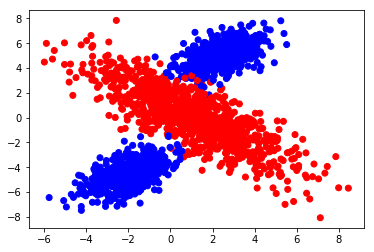

In [20]:
# 2. Plot data
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr) #http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter
plt.show()

Split the data for 5 fold cross validation

In [21]:
# Split the data into training data and test data
Xtrain=[]
Xtest = np.split(X,5)
for i in range(0,5):
    Xtrain.append(np.asarray([x for x in X if x not in Xtest[i]]))
Xtrain = np.asarray(Xtrain)
ytest = np.split(y,5)
ytrain = []
ytrain.append(y[400:2000])
ytrain.append(np.concatenate((y[:400],y[800:2000])))
ytrain.append(np.concatenate((y[:800],y[1200:2000])))
ytrain.append(np.concatenate((y[:1200],y[1600:2000])))
ytrain.append(y[:1600])
ytrain = np.asarray(ytrain)

Initialize the model

In [22]:
# 3. Initialize model
input_dim = np.shape(X)[1]
output_dim = np.max(y) + 1
hidden_dim = 14
nnet = NeuralNetwork(input_dim, hidden_dim, output_dim)

Train and test the model

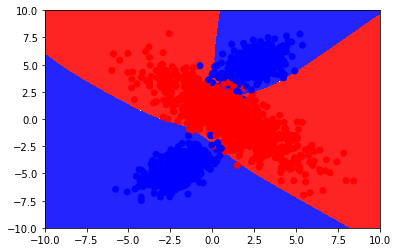

ACCURACY:  0.9825
CONFUSION MATRIX: 
 [[196.   4.]
 [  3. 197.]]


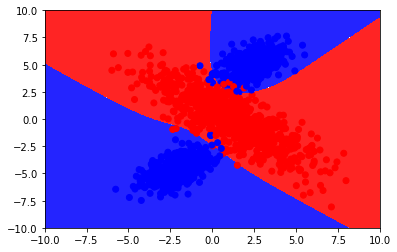

ACCURACY:  0.99
CONFUSION MATRIX: 
 [[186.   1.]
 [  3. 210.]]


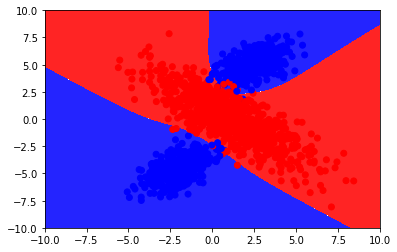

ACCURACY:  0.985
CONFUSION MATRIX: 
 [[195.   2.]
 [  4. 199.]]


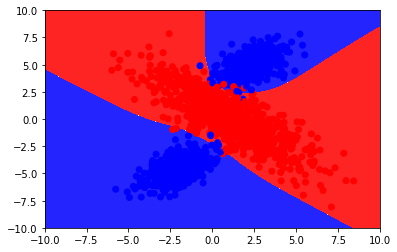

ACCURACY:  0.985
CONFUSION MATRIX: 
 [[215.   4.]
 [  2. 179.]]


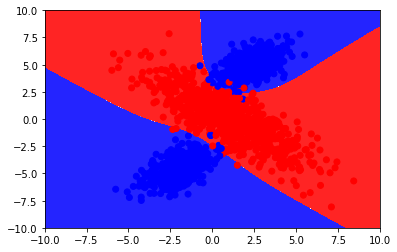

ACCURACY:  0.9925
CONFUSION MATRIX: 
 [[195.   2.]
 [  1. 202.]]
Average accuracy:  0.9869999999999999


In [25]:
# 4. Train and test the model
acc_total = 0
for j in range(0,5):
    nnet.fit(Xtrain[j],ytrain[j],1000,0.01,False)        # Trains the model
    plot_decision_boundary(nnet, Xtrain[j], ytrain[j])  # Plot decision boundary after training
    acc = 0
    y_pred = nnet.predict(Xtest[j])                     # Evaluating the model by prediction
    con_mat = np.zeros((output_dim, output_dim))          # Calculate and print confusion matrix
    for i in range(len(y_pred)):
        con_mat[y_pred[i], ytest[j][i]] += 1
        if ytest[j][i] == y_pred[i]:
            acc += 1
    acc = acc/len(y_pred)
    acc_total +=acc
    print ('ACCURACY: ', acc)
    print ('CONFUSION MATRIX: \n', con_mat)
print("Average accuracy: ",acc_total/5)

### 2b. Model for linear dataset with 5 fold cross validation
Load the data

In [26]:
# 1. Load data
X = np.genfromtxt('DATA/data_linearX.csv', delimiter=',')
y = np.genfromtxt('DATA/data_linearY.csv', delimiter=',').astype(np.int64)

Plot the data

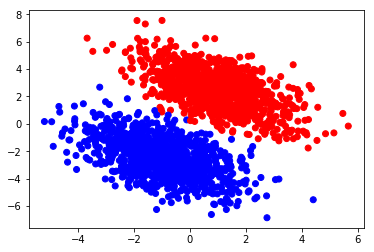

In [27]:
# 2. plot data
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr) #http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter
plt.show()

Split the data for 5 fold cross validation

In [28]:
# Split the data into training data and test data for 5 fold cross validation
Xtrain=[]
Xtest = np.split(X,5)
for i in range(0,5):
    Xtrain.append(np.asarray([x for x in X if x not in Xtest[i]]))
Xtrain = np.asarray(Xtrain)
ytest = np.split(y,5)
ytrain = []
ytrain.append(y[400:2000])
ytrain.append(np.concatenate((y[:400],y[800:2000])))
ytrain.append(np.concatenate((y[:800],y[1200:2000])))
ytrain.append(np.concatenate((y[:1200],y[1600:2000])))
ytrain.append(y[:1600])
ytrain = np.asarray(ytrain)

Initialize the model

In [29]:
# 3. Initialize model
input_dim = np.shape(X)[1]
output_dim = np.max(y) + 1
hidden_dim = 14
nnet = NeuralNetwork(input_dim, hidden_dim, output_dim)

Train and test the model

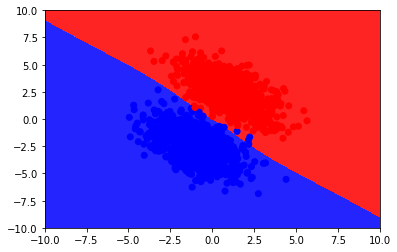

ACCURACY:  0.9975
CONFUSION MATRIX: 
 [[202.   0.]
 [  1. 197.]]


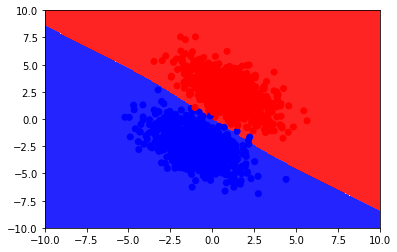

ACCURACY:  0.9975
CONFUSION MATRIX: 
 [[198.   1.]
 [  0. 201.]]


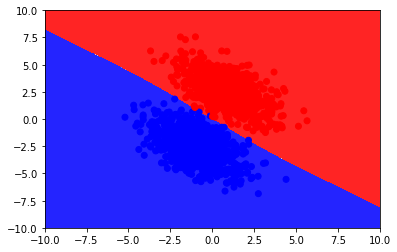

ACCURACY:  0.995
CONFUSION MATRIX: 
 [[203.   0.]
 [  2. 195.]]


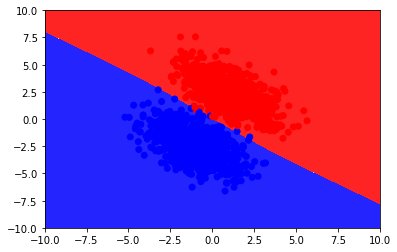

ACCURACY:  1.0
CONFUSION MATRIX: 
 [[192.   0.]
 [  0. 208.]]


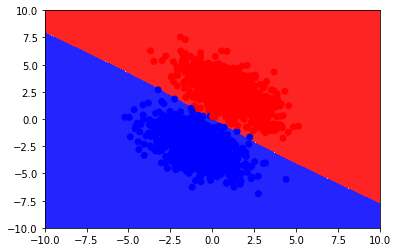

ACCURACY:  1.0
CONFUSION MATRIX: 
 [[202.   0.]
 [  0. 198.]]
Average accuracy:  0.998


In [30]:
# 4. Without L2 regularization
acc_total = 0
for j in range(0,5):
    nnet.fit(Xtrain[j],ytrain[j],1000,0.01,False)        # Trains the model
    plot_decision_boundary(nnet, Xtrain[j], ytrain[j])   # Plot decision boundary after training
    acc = 0
    y_pred = nnet.predict(Xtest[j])                      # Evaluating the model by prediction
    con_mat = np.zeros((output_dim, output_dim))         # Calculate and print confusion matrix
    for i in range(len(y_pred)):
        con_mat[y_pred[i], ytest[j][i]] += 1
        if ytest[j][i] == y_pred[i]:
            acc += 1
    acc = acc/len(y_pred)
    acc_total += acc
    print ('ACCURACY: ', acc)
    print ('CONFUSION MATRIX: \n', con_mat)
print("Average accuracy: ",acc_total/5)

### 3. Effect of learning rate on Accuracy

We use the non linear dataset for demonstration
<br>Initialize the data

In [34]:
# Initialize the data
X = np.genfromtxt('DATA/data_nonLinearX.csv', delimiter=',')
y = np.genfromtxt('DATA/data_nonLinearY.csv', delimiter=',').astype(np.int64)
input_dim = np.shape(X)[1]
output_dim = np.max(y) + 1
hidden_dim = 14
nnet = NeuralNetwork(input_dim, hidden_dim, output_dim)

Initialize the weights and biases

In [35]:
theta1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
theta2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
bias1 = np.zeros((1, hidden_dim))
bias2 = np.zeros((1, output_dim))

Iterate through multiple alpha values keeping other parameters constant

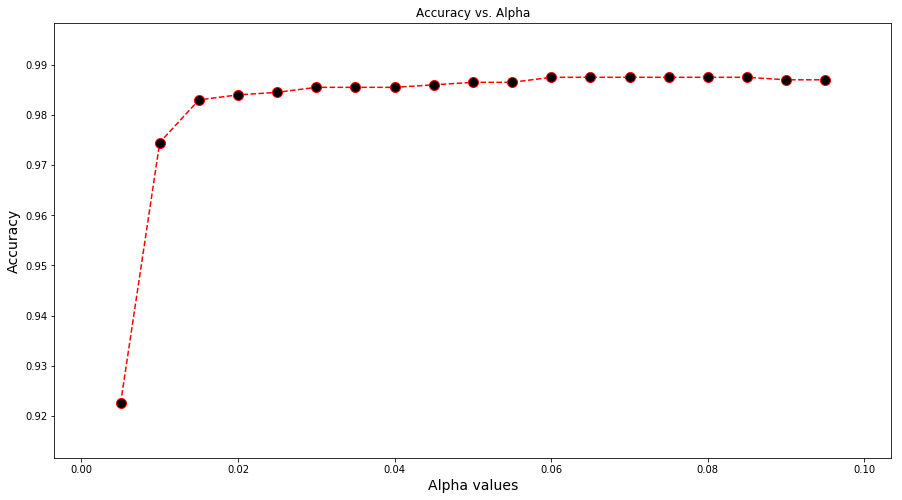

In [37]:
# demonstrating the effect of change in learning rate on training of the network
alpha_list = list(np.arange(0.005,0.1,0.005))                       # range of alpha values to test
acc_list = []
for a in alpha_list:
    nnet.theta1 = copy.deepcopy(theta1)
    nnet.theta2 = copy.deepcopy(theta2)
    nnet.bias1 = copy.deepcopy(bias1)
    nnet.bias2 = copy.deepcopy(bias2)
    nnet.fit(X, y, 1000, alpha=a)
    accuracy = 0
    y_pred = nnet.predict(X)
    con_mat = np.zeros((output_dim, output_dim))
    for i in range(len(y_pred)):
        con_mat[y_pred[i], y[i]] += 1
        if y[i] == y_pred[i]:
            accuracy += 1
    accuracy = accuracy / len(y_pred)
    acc_list.append(accuracy)

# Plot the accuracy against the alpha value
plt.figure(figsize=(15,8))
plt.scatter(alpha_list, acc_list)
plt.title ('Accuracy vs. Alpha')
plt.xlabel('Alpha values', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(alpha_list, acc_list, color ='red', linestyle = 'dashed',
marker ='o', markerfacecolor ='black', markersize =10)
plt.show()

### 5. L2 Regularization
We use the non linear dataset to demonstrate the effect of L2 Regularization
<br>Load the data

In [38]:
# 1. Load data
X = np.genfromtxt('DATA/data_nonLinearX.csv', delimiter=',')
y = np.genfromtxt('DATA/data_nonLinearY.csv', delimiter=',').astype(np.int64)

Split the data

In [39]:
# Split the data into training data and test data
Xtrain=[]
Xtest = np.split(X,5)
for i in range(0,5):
    Xtrain.append(np.asarray([x for x in X if x not in Xtest[i]]))
Xtrain = np.asarray(Xtrain)
ytest = np.split(y,5)
ytrain = []
ytrain.append(y[400:2000])
ytrain.append(np.concatenate((y[:400],y[800:2000])))
ytrain.append(np.concatenate((y[:800],y[1200:2000])))
ytrain.append(np.concatenate((y[:1200],y[1600:2000])))
ytrain.append(y[:1600])
ytrain = np.asarray(ytrain)

Initialize the model

In [43]:
# 2. Initialize model
input_dim = np.shape(X)[1]
output_dim = np.max(y) + 1
hidden_dim = 14
nnet = NeuralNetwork(input_dim, hidden_dim, output_dim)

Test model without L2 Regularization

Cost 0.0 : 2.470185873566212
Cost 1.0 : 1.2772784996468614
Cost 2.0 : 1.0570354314648864
Cost 3.0 : 0.9298182754184344
Cost 4.0 : 0.837219678622451
Cost 5.0 : 0.7590770575034091
Cost 6.0 : 0.6894247930221095
Cost 7.0 : 0.6264507025357203
Cost 8.0 : 0.5694488489500431
Cost 9.0 : 0.5179815557551575


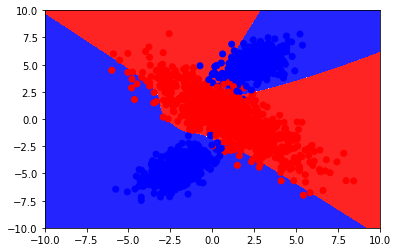

ACCURACY:  0.945
CONFUSION MATRIX: 
 [[189.  12.]
 [ 10. 189.]]
Cost 0.0 : 0.4798485347211638
Cost 1.0 : 0.436311132395811
Cost 2.0 : 0.3976853015365137
Cost 3.0 : 0.3632223808493346
Cost 4.0 : 0.3328612067113974
Cost 5.0 : 0.30667378046544946
Cost 6.0 : 0.28446017797445156
Cost 7.0 : 0.2656424934216773
Cost 8.0 : 0.24955312207495392
Cost 9.0 : 0.23564232884975916


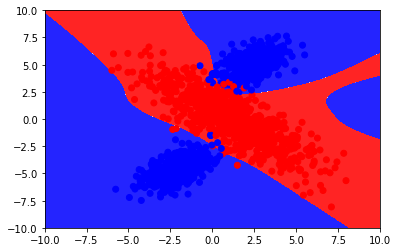

ACCURACY:  0.9875
CONFUSION MATRIX: 
 [[186.   2.]
 [  3. 209.]]
Cost 0.0 : 0.21396377716343692
Cost 1.0 : 0.2034938882336915
Cost 2.0 : 0.1942285359101
Cost 3.0 : 0.18594926837618858
Cost 4.0 : 0.178505913848885
Cost 5.0 : 0.17177806057093312
Cost 6.0 : 0.16566701114212307
Cost 7.0 : 0.16009109253061254
Cost 8.0 : 0.15498221392056696
Cost 9.0 : 0.1502832226408247


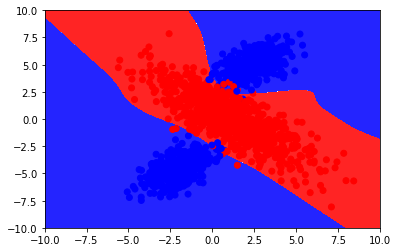

ACCURACY:  0.985
CONFUSION MATRIX: 
 [[195.   2.]
 [  4. 199.]]
Cost 0.0 : 0.1504613758031747
Cost 1.0 : 0.14642596166217295
Cost 2.0 : 0.14283498237341877
Cost 3.0 : 0.13951808606813632
Cost 4.0 : 0.136427727301365
Cost 5.0 : 0.13353712837950074
Cost 6.0 : 0.1308258158769275
Cost 7.0 : 0.12827659475275596
Cost 8.0 : 0.12587461682833612
Cost 9.0 : 0.12360691779423004


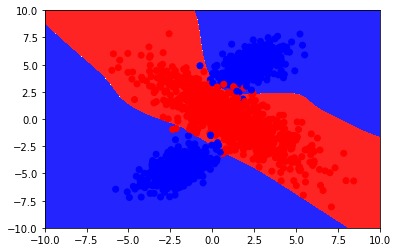

ACCURACY:  0.985
CONFUSION MATRIX: 
 [[215.   4.]
 [  2. 179.]]
Cost 0.0 : 0.12481474547786381
Cost 1.0 : 0.1223182342061832
Cost 2.0 : 0.12022257632926976
Cost 3.0 : 0.11828334816641871
Cost 4.0 : 0.11645459132631586
Cost 5.0 : 0.11472072017605563
Cost 6.0 : 0.11307276955789287
Cost 7.0 : 0.11150387812197271
Cost 8.0 : 0.11000824090931431
Cost 9.0 : 0.10858077923439688


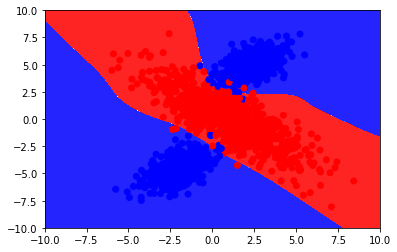

ACCURACY:  0.99
CONFUSION MATRIX: 
 [[194.   2.]
 [  2. 202.]]
Average accuracy:  0.9785


In [44]:
# 3. Without L2 regularization
acc_total = 0
# Here we print the cost of every 100th epoch to show the change in cost
for j in range(0,5):
    nnet.fit(Xtrain[j],ytrain[j],1000,0.01,True)        # Trains the model
    plot_decision_boundary(nnet, Xtrain[j], ytrain[j])   # Plot decision boundary after training
    acc = 0
    y_pred = nnet.predict(Xtest[j])                      # Evaluating the model by prediction
    con_mat = np.zeros((output_dim, output_dim))           # Calculate and print confusion matrix
    for i in range(len(y_pred)):
        con_mat[y_pred[i], ytest[j][i]] += 1
        if ytest[j][i] == y_pred[i]:
            acc += 1
    acc = acc/len(y_pred)
    acc_total += acc
    print ('ACCURACY: ', acc)
    print ('CONFUSION MATRIX: \n', con_mat)
print("Average accuracy: ",acc_total/5)

Test the model with L2 Regularization

Cost 0.0 : 2.474815779839021
Cost 1.0 : 1.281742272343142
Cost 2.0 : 1.0616197156944114
Cost 3.0 : 0.9345207584662133
Cost 4.0 : 0.841999346554954
Cost 5.0 : 0.763898434083158
Cost 6.0 : 0.6942666549587696
Cost 7.0 : 0.6313026661591183
Cost 8.0 : 0.5743075548514148
Cost 9.0 : 0.5228483561813793


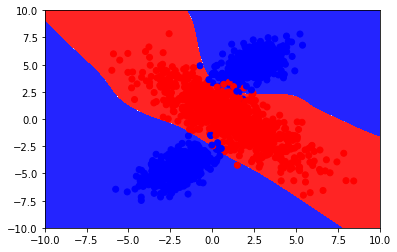

ACCURACY:  0.945
CONFUSION MATRIX: 
 [[189.  12.]
 [ 10. 189.]]
Cost 0.0 : 0.48466760120221536
Cost 1.0 : 0.4411443840898788
Cost 2.0 : 0.40254459200551174
Cost 3.0 : 0.3681319729019321
Cost 4.0 : 0.33785913137874746
Cost 5.0 : 0.31179235199976607
Cost 6.0 : 0.2897045253780439
Cost 7.0 : 0.2709980396190605
Cost 8.0 : 0.25500319751369227
Cost 9.0 : 0.24117421103512604


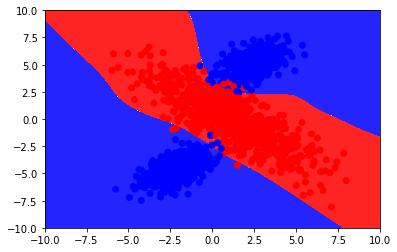

ACCURACY:  0.9875
CONFUSION MATRIX: 
 [[186.   2.]
 [  3. 209.]]
Cost 0.0 : 0.21964956223187027
Cost 1.0 : 0.2092442544203555
Cost 2.0 : 0.20003613847322776
Cost 3.0 : 0.19180908369443672
Cost 4.0 : 0.18441359482025244
Cost 5.0 : 0.1777297692284606
Cost 6.0 : 0.17165934614394826
Cost 7.0 : 0.16612103619053006
Cost 8.0 : 0.1610470896564903
Cost 9.0 : 0.1563806601261532


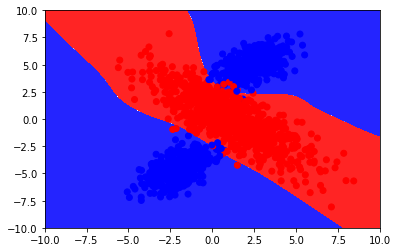

ACCURACY:  0.985
CONFUSION MATRIX: 
 [[195.   2.]
 [  4. 199.]]
Cost 0.0 : 0.15659196926008012
Cost 1.0 : 0.15259248554919663
Cost 2.0 : 0.1490305115099018
Cost 3.0 : 0.14574014404294067
Cost 4.0 : 0.14267474950234355
Cost 5.0 : 0.1398078781435645
Cost 6.0 : 0.13711927516831962
Cost 7.0 : 0.1345919333185968
Cost 8.0 : 0.1322111759698723
Cost 9.0 : 0.1299641981573874


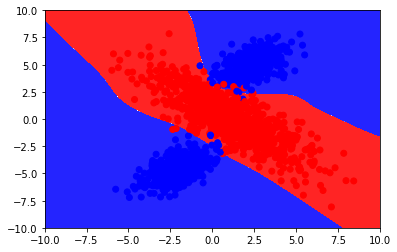

ACCURACY:  0.9875
CONFUSION MATRIX: 
 [[215.   3.]
 [  2. 180.]]
Cost 0.0 : 0.13114755638256403
Cost 1.0 : 0.1286847276106148
Cost 2.0 : 0.12661391293307545
Cost 3.0 : 0.12469788281652602
Cost 4.0 : 0.12289193169668482
Cost 5.0 : 0.12118088635807801
Cost 6.0 : 0.11955602120228816
Cost 7.0 : 0.1180106550143441
Cost 8.0 : 0.11653912861086768
Cost 9.0 : 0.11513648260699592


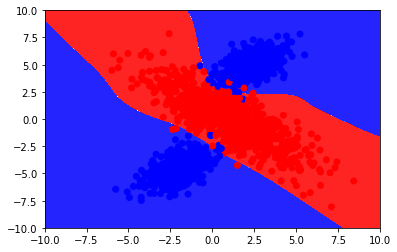

ACCURACY:  0.99
CONFUSION MATRIX: 
 [[194.   2.]
 [  2. 202.]]
Average accuracy:  0.9790000000000001


In [45]:
# 4. With L2 regularization
acc_total = 0
# Here we print the cost of every 100th epoch to show the change in cost
for j in range(0,5):
    nnet.fit_with_regularization(Xtrain[j],ytrain[j],1000,0.01,0.7,True)  # Trains the model
    plot_decision_boundary(nnet, Xtrain[j], ytrain[j])
    acc = 0
    y_pred = nnet.predict_with_regularization(Xtest[j])                   # Evaluating the model by prediction 
    con_mat = np.zeros((output_dim, output_dim))                          # Calculate and print confusion matrix
    for i in range(len(y_pred)):
        con_mat[y_pred[i], ytest[j][i]] += 1
        if ytest[j][i] == y_pred[i]:
            acc += 1
    acc = acc/len(y_pred)
    acc_total += acc
    print ('ACCURACY: ', acc)
    print ('CONFUSION MATRIX: \n', con_mat)
print("Average accuracy: ",acc_total/5)

### 6. Digit Data model
Load the data

In [47]:
# 1. Load the data
Xtrain = np.genfromtxt('DATA/Digit_X_train.csv', delimiter=',')
ytrain = np.genfromtxt('DATA/Digit_y_train.csv', delimiter=',').astype(np.int64)
Xtest = np.genfromtxt('DATA/Digit_X_test.csv', delimiter=',')
ytest = np.genfromtxt('DATA/Digit_y_test.csv', delimiter=',').astype(np.int64)

Initialize the model

In [48]:
# 2. Initialize model
input_dim = np.shape(Xtrain)[1]
output_dim = np.max(ytrain) + 1
hidden_dim = 14
nnet = NeuralNetwork(input_dim, hidden_dim, output_dim)

Train the data

In [49]:
# 3. Train the data
nnet.fit(Xtrain, ytrain, 5000, 0.01, False)

0

Test the model

In [50]:
# 4. Test the model
#plot_decision_boundary(nnet, Xtrain, ytrain)   # Plot decision boundary after training
accuracy = 0
y_pred = nnet.predict(Xtest)
con_mat = np.zeros((output_dim, output_dim))
for i in range(len(y_pred)):
    con_mat[y_pred[i], ytest[i]] += 1
    if ytest[i] == y_pred[i]:
        accuracy += 1
accuracy = accuracy / len(y_pred)
print ('ACCURACY: ', accuracy)
print ('CONFUSION MATRIX: \n', con_mat)

ACCURACY:  0.9210233592880979
CONFUSION MATRIX: 
 [[85.  0.  0.  0.  3.  0.  0.  0.  0.  0.]
 [ 0. 74.  0.  0.  1.  0.  1.  0.  3.  0.]
 [ 0.  0. 82.  1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  3. 82.  0.  0.  0.  0.  0.  2.]
 [ 1.  5.  0.  0. 84.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  3.  0. 86.  0.  0.  3.  2.]
 [ 1.  0.  0.  0.  1.  1. 90.  0.  1.  0.]
 [ 0.  0.  0.  2.  0.  0.  0. 83.  0.  1.]
 [ 0.  0.  0.  3.  2.  0.  0.  2. 77.  2.]
 [ 0. 12.  1.  0.  1.  4.  0.  2.  4. 85.]]
